#**Taxi game using different RL techniques**#

Group Name - Project Impossible

Group Number - 17

Group Members - 

> 1.   Abdullah Abu Sayed    (170041004)
2.   Shehreen Azad           (170041005)
3.   Noshin Faiyrooz         (170041018)
4.   Mosammat Rifaa Juhani   (170041023)
 

##**Problem Statement**##
For this project, we trained and tested our approaches on a simulation of a self-driving taxi environment, Taxi-v3, created by OpenAI Gym. Specifically, we implemented three reinforcement learning algorithms for Taxi-v3: Q-learning, SARSA, and Deep Q-networks (DQN) and compared the results. 

##**Game Environment Description**##

There are four designated locations in the grid world indicated by R(ed), B(lue), G(reen), and Y(ellow). When the episode starts, the taxi starts off at a random square and the passenger is at a random location. The taxi drive to the passenger's location, pick up the passenger, drive to the passenger's destination (another one of the four specified locations), and then drop off the passenger. Once the passenger is dropped off, the episode ends. There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is the taxi), and 4 destination locations. Actions: There are 6 discrete deterministic actions:

      0: move south
      1: move north
      2: move east
      3: move west
      4: pickup passenger
      5: dropoff passenger


Rewards: There is a reward of -1 for each action and an additional reward of +20 for delievering the passenger. There is a reward of -10 for executing actions "pickup" and "dropoff" illegally. Rendering: 

      blue: passenger
      magenta: destination
      yellow: empty taxi
      green: full taxi
      other letters: locations


##**Conclusion**##
DQN performs the best in terms of test rewards over a certain number of episodes.      



# Environment Setup

In [ ]:
from IPython.display import clear_output
!pip install keras-rl2
clear_output()
print('keras-rl2 okay')

keras-rl2 okay


In [ ]:
import gym
import numpy as np
import random
from gym import envs
import keras
import tensorflow as tf

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Reshape
from keras.layers.embeddings import Embedding
from tensorflow.keras.optimizers import Adam

import time
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

from rl.agents.dqn import DQNAgent
from rl.policy import Policy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory

In [ ]:
ENV_NAME = "Taxi-v3"
env = gym.make(ENV_NAME)
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [ ]:
action_size = env.action_space.n
state_size = env.observation_space.n

print("Number of actions: %d" % action_size)
print("Number of states: %d" % state_size)

Number of actions: 6
Number of states: 500


In [ ]:
np.random.seed(123)
env.seed(123)

[123]

In [ ]:
env.reset()
env.step(env.action_space.sample())[0]

331

# Q Learning 

In [ ]:
class Agent:
  
  def __init__(self, n_states, n_actions, decay_rate=0.4212, learning_rate=0.6711, gamma=0.9891):
    self.n_actions = n_actions
    self.q_table = np.zeros((n_states, n_actions))
    self.epsilon = 0.0004
    self.max_epsilon = 1.0
    self.min_epsilon = 0.0
    self.decay_rate = decay_rate
    self.learning_rate = learning_rate
    self.gamma = gamma 
    self.epsilons_ = []
    
  def choose_action(self, explore=True):
    exploration_tradeoff = np.random.uniform(0, 1)
    
    if explore and exploration_tradeoff < self.epsilon:
      # exploration
      return np.random.randint(self.n_actions)    
    else:
      # exploitation (taking the biggest Q value for this state)
      return np.argmax(self.q_table[state, :])
  
  def learn(self, state, action, reward, next_state, done, episode):
    # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
    self.q_table[state, action] = self.q_table[state, action] + self.learning_rate * (reward + self.gamma * np.max(self.q_table[new_state, :]) - self.q_table[state, action])
    
    if done:
      # Reduce epsilon to decrease the exploration over time
      self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon) * np.exp(-self.decay_rate * episode)
      self.epsilons_.append(self.epsilon)

In [ ]:
total_episodes = 60000
total_test_episodes = 10

agent = Agent(env.observation_space.n, env.action_space.n)

In [ ]:

untrained_frames = []

for episode in range(total_test_episodes):
    state = env.reset()

    step = 1
    
    while True:
        action = agent.choose_action()
        
        new_state, reward, done, info = env.step(action)        
        
        untrained_frames.append({
          'frame': env.render(mode='ansi'),
          'state': state,
          'episode': episode + 1,
          'step': step,
          'reward': reward
        })
        
        if done:
            step = 0
            break
        state = new_state
        step += 1

In [ ]:
def print_frames(frames):
  for i, frame in enumerate(frames):
    clear_output(wait=True)
    print(frame['frame'])
    print(f"Episode: {frame['episode']}")
    print(f"Timestep: {frame['step']}")    
    print(f"State: {frame['state']}")
    print(f"Reward: {frame['reward']}")
    time.sleep(.1)

In [ ]:
print_frames(untrained_frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

Episode: 10
Timestep: 200
State: 449
Reward: -1


**Training**

In [ ]:
rewards = []

for episode in range(total_episodes):
    state = env.reset()
    episode_rewards = []
    
    while True:
            
        action = agent.choose_action()
        
        # Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward, done, info = env.step(action)
        
        agent.learn(state, action, reward, new_state, done, episode)

        state = new_state
        
        episode_rewards.append(reward)
        
        if done == True:
          break
          
    rewards.append(np.mean(episode_rewards))

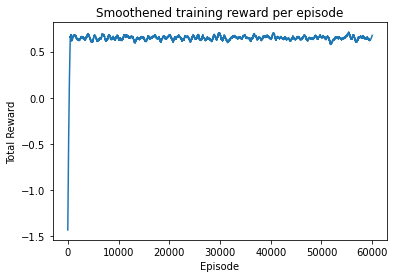

In [ ]:
plt.plot(savgol_filter(rewards, 1001, 2))
#plt.ylim((-4,1))
plt.title("Smoothened training reward per episode")
plt.xlabel('Episode');
plt.ylabel('Total Reward');

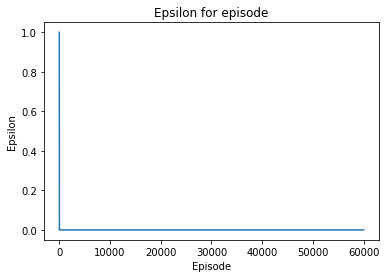

In [ ]:
plt.plot(agent.epsilons_)
plt.title("Epsilon for episode")
plt.xlabel('Episode');
plt.ylabel('Epsilon');

**Evaluation**

In [ ]:
frames = []

rewardsT = []

for episode in range(total_test_episodes):
    state = env.reset()
    episode_rewards = []

    step = 1
    
    while True:
        action = agent.choose_action(explore=False)
        
        new_state, reward, done, info = env.step(action)        
        
        frames.append({
          'frame': env.render(mode='ansi'),
          'state': state,
          'episode': episode + 1,
          'step': step,
          'reward': reward
        })
        
        episode_rewards.append(reward)
        
        if done:
            step = 0
            break
        state = new_state
        step += 1
    
    rewardsT.append(np.mean(episode_rewards))

env.close()

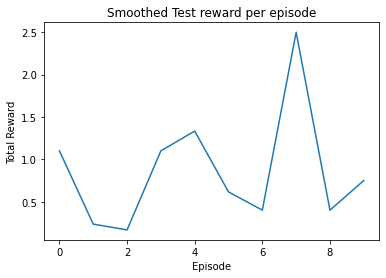

In [ ]:
plt.plot(rewardsT)
plt.title("Smoothed Test reward per episode")
plt.xlabel('Episode');
plt.ylabel('Total Reward');

In [ ]:
print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Episode: 10
Timestep: 12
State: 16
Reward: 20


# SARSA

In [ ]:
class SarsaAgent:
  
  def __init__(self, n_states, n_actions, decay_rate=0.8453 , learning_rate=0.1171, gamma=0.9383):
    self.n_actions = n_actions
    self.q_table = np.zeros((n_states, n_actions))
    self.epsilon = 0.0140
    self.max_epsilon = 1.0
    self.min_epsilon = 0.001
    self.decay_rate = decay_rate
    self.learning_rate = learning_rate
    self.gamma = gamma 
    self.epsilons_ = []
    
  def choose_action(self, explore=False):
    exploration_tradeoff = np.random.uniform(0, 1)
    
    if explore or exploration_tradeoff < self.epsilon:
      # exploration
      return np.random.randint(self.n_actions) 

    else:
      # exploitation (taking the biggest Q value for this state)
      return np.argmax(self.q_table[state, :])
  
  def learn(self, state, action, reward, next_state, next_action, done, episode):
    # Update Q(s,a):= Q(s,a) + lr [(R(s,a) + gamma * Q(s',a')) - Q(s,a)]
    predict = self.q_table[state, action]
    target = reward + self.gamma * self.q_table[next_state, next_action]
    self.q_table[state, action] = self.q_table[state, action] + self.learning_rate * (target - predict)

    if done:
      # Reduce epsilon to decrease the exploration over time
      self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon) * np.exp(-self.decay_rate * episode)
      #self.epsilon *= self.decay_rate
      self.epsilons_.append(self.epsilon)

In [ ]:
total_episodesSarsa = 60000
total_test_episodesSarsa = 10

agent2 = SarsaAgent(env.observation_space.n, env.action_space.n)

In [ ]:
untrained_frames2 = []

for episode in range(total_test_episodesSarsa):
    state = env.reset()

    step = 1
    
    while True:
        action = agent2.choose_action()
        
        new_state, reward, done, info = env.step(action)        
        
        untrained_frames2.append({
          'frame': env.render(mode='ansi'),
          'state': state,
          'episode': episode + 1,
          'step': step,
          'reward': reward
        })
        
        if done:
            step = 0
            break
        state = new_state
        step += 1


In [ ]:
print_frames(untrained_frames2)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Episode: 10
Timestep: 130
State: 479
Reward: 20


**Training**

In [ ]:
rewards2 = []

for episode in range(total_episodesSarsa):
    state = env.reset()
    episode_rewards = []
    
    while True:
            
        action = agent2.choose_action()
        
        # Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward, done, info = env.step(action)
        new_action = agent2.choose_action(new_state)

        agent2.learn(state, action, reward, new_state, new_action, done, episode)

        state = new_state
        
        episode_rewards.append(reward)
        
        if done == True:
          break
          
    rewards2.append(np.mean(episode_rewards))


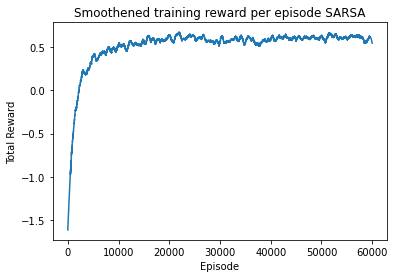

In [ ]:

plt.plot(savgol_filter(rewards2, 1001, 2))
plt.title("Smoothened training reward per episode SARSA")
plt.xlabel('Episode');
plt.ylabel('Total Reward');

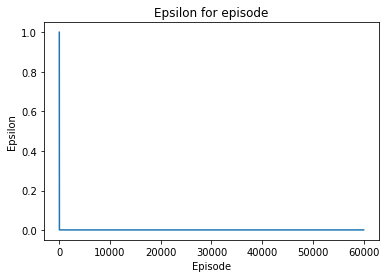

In [ ]:
plt.plot(agent2.epsilons_)
plt.title("Epsilon for episode")
plt.xlabel('Episode');
plt.ylabel('Epsilon');

**Evaluation**

In [ ]:
frames2 = []

rewards2T = []

for episode in range(total_test_episodesSarsa):
    state = env.reset()
    episode_rewards = []

    step = 1
    
    while True:
        action = agent2.choose_action(explore=False)
        
        new_state, reward, done, info = env.step(action)       
        
        frames2.append({
          'frame': env.render(mode='ansi'),
          'state': state,
          'episode': episode + 1,
          'step': step,
          'reward': reward
        })
        
        episode_rewards.append(reward)
        
        if done:
            step = 0
            break
        state = new_state
        step += 1
    
    rewards2T.append(np.mean(episode_rewards))

env.close()

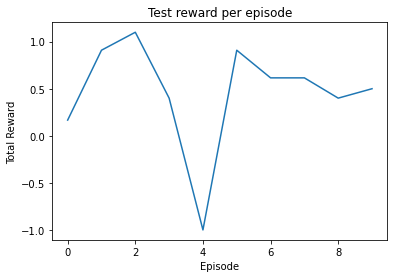

In [ ]:
plt.plot(rewards2T)
plt.title("Test reward per episode")
plt.xlabel('Episode');
plt.ylabel('Total Reward');

In [ ]:
print_frames(frames2)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Episode: 10
Timestep: 14
State: 97
Reward: 20


# Deep Q-Network (DQN)

In [ ]:
model_only_embedding = Sequential()
model_only_embedding.add(Embedding(500, 6, input_length=1))
model_only_embedding.add(Reshape((6,)))
print(model_only_embedding.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1, 6)              3000      
_________________________________________________________________
reshape (Reshape)            (None, 6)                 0         
Total params: 3,000
Trainable params: 3,000
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model = Sequential()
model.add(Embedding(500, 10, input_length=1))
model.add(Reshape((10,)))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(action_size, activation='linear'))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1, 10)             5000      
_________________________________________________________________
reshape_1 (Reshape)          (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                550       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 306       
Total params: 10,956
Trainable params: 10,956
Non-trainable params: 0
__________________________________________________

**Training**

In [ ]:
memory = SequentialMemory(limit=50000, window_length=1)
policy = EpsGreedyQPolicy()
dqn_only_embedding = DQNAgent(model=model, nb_actions=action_size, memory=memory, nb_steps_warmup=500, target_model_update=1e-2, policy=policy)
dqn_only_embedding.compile(Adam(lr=1e-3), metrics=['mae'])
dqn_only_embedding.fit(env, nb_steps=600000, visualize=False, verbose=1, nb_max_episode_steps=99, log_interval=60000)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Training for 600000 steps ...
Interval 1 (0 steps performed)


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


60000/60000 [==============================] - 491s 8ms/step - reward: 0.1577
4067 episodes - episode_reward: 2.329 [-90.000, 15.000] - loss: 0.001 - mae: 7.348 - mean_q: 12.673 - prob: 1.000

Interval 2 (60000 steps performed)
60000/60000 [==============================] - 517s 9ms/step - reward: 0.1575
4058 episodes - episode_reward: 2.328 [-41.000, 15.000] - loss: 0.001 - mae: 7.342 - mean_q: 12.670 - prob: 1.000

Interval 3 (120000 steps performed)
60000/60000 [==============================] - 527s 9ms/step - reward: 0.1478
4059 episodes - episode_reward: 2.184 [-82.000, 15.000] - loss: 0.001 - mae: 7.358 - mean_q: 12.700 - prob: 1.000

Interval 4 (180000 steps performed)
60000/60000 [==============================] - 528s 9ms/step - reward: 0.1547
4076 episodes - episode_reward: 2.275 [-46.000, 15.000] - loss: 0.001 - mae: 7.367 - mean_q: 12.718 - prob: 1.000

Interval 5 (240000 steps performed)
60000/60000 [==============================] - 531s 9ms/step - reward: 0.1603
4051 ep

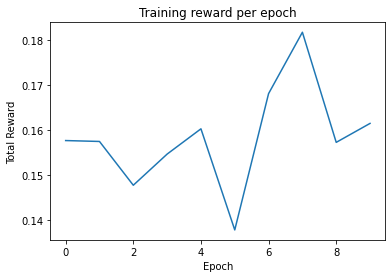

In [ ]:
rewards33 = [0.1577, 0.1575,0.1478, 0.1547, 0.1603,0.1379,0.1681,0.1817,0.1573,0.1615]
plt.plot(rewards33)
plt.title("Training reward per epoch")
plt.xlabel('Epoch');
plt.ylabel('Total Reward');

**Evaluation**

In [ ]:
dqn_only_embedding.test(env, nb_episodes=10, visualize=False, nb_max_episode_steps=99)

Testing for 10 episodes ...
Episode 1: reward: 8.000, steps: 13
Episode 2: reward: 9.000, steps: 12
Episode 3: reward: 3.000, steps: 18
Episode 4: reward: 12.000, steps: 9
Episode 5: reward: 10.000, steps: 11
Episode 6: reward: 12.000, steps: 9
Episode 7: reward: 7.000, steps: 14
Episode 8: reward: 8.000, steps: 13
Episode 9: reward: 12.000, steps: 9
Episode 10: reward: 6.000, steps: 15


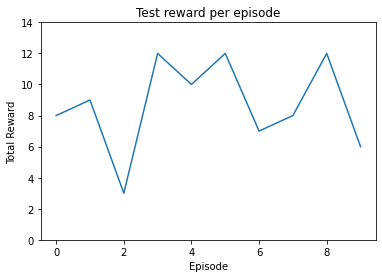

In [ ]:
rewards3 = [8.0,9.0,3.0,12.0,10.0,12.0,7.0,8.0,12.0,6.0]
plt.plot(rewards3)
plt.title("Test reward per episode")
plt.ylim((0,14))
plt.xlabel('Episode');
plt.ylabel('Total Reward');